In [2]:
# import torch
# import torchaudio
import numpy as np
from tqdm import tqdm
from pathlib import Path
import soundfile as sf
import pandas as pd
from functools import partial
from librosa import stft
import librosa
from librosa.display import specshow
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import lfilter
from IPython.display import Audio

from utils import chain_functions

prefilter = partial(lfilter, [1, -1], [1, -0.995])

## Define Metrics Functions

In [3]:
def ldr(sr: int, tau_short: float, tau_long: float, x: np.ndarray):
    x_sq = np.maximum(x * x, 1e-16)
    a_short = 1 - np.exp(-1 / sr / tau_short)
    a_long = 1 - np.exp(-1 / sr / tau_long)

    env_short = lfilter([a_short], [1, a_short - 1], x_sq)
    env_long = lfilter([a_long], [1, a_long - 1], x_sq)

    l = 10 * (np.log10(env_short) - np.log10(env_long))
    return np.sqrt(np.mean(l * l))


def esr(pred, target):
    target_norm = target @ target

    diff = pred - target
    return diff @ diff / target_norm


## Define Audio Paths

In [4]:
target_path = Path(r"D:\Datasets\SignalTrain_LA2A_Dataset_1.1")
foura2a_path = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\4A2A")
GRU_path = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\4A2A_GRU")
uad_path = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\UAD")
ca2a_path = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\CA-2A")
cla2a_path = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\CLA-2A")
test_path = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\test")

In [4]:
compare_files = list(
    map(
        lambda f: f.relative_to(target_path),
        filter(
            lambda x: sf.info(x).frames > 44100 * 600,
            target_path.glob(f"**/*3c*.wav")
        )
    )
)
peak_values = [int(f.stem.split("__")[-1]) for f in compare_files]
modes = [int(f.stem.split("__")[-2]) for f in compare_files]
target_files = [target_path / f for f in compare_files]
rendered_paths = [foura2a_path, GRU_path, uad_path, ca2a_path, cla2a_path]
labels = ["4A2A", "4A2A+GRU", "UAD", "CA-2A", "CLA-2A"]
# rendered_paths = [ca2a_path, cla2a_path]
# labels = ["CA-2A", "CLA-2A"]

In [ ]:
ldr_func = partial(ldr, 44100, 0.05, 3)

metrics = {
    "ESR": lambda *args: esr(*args),
    "LDR": lambda pred, target: ldr_func(pred) - ldr_func(target)
}

data = []
for method, p in zip(labels, rendered_paths):
    for x, y, mode, peak_value in tqdm(
            map(
                lambda args: tuple(map(chain_functions(lambda x: sf.read(x)[0], prefilter), args[:2])) + args[2:],
                filter(lambda x: x[0].exists(),
                       zip([p / f for f in compare_files], target_files, modes, peak_values))
            )
    ):
        x = x[:y.shape[0]]
        y = y[:x.shape[0]]

        data.append(
            [method, mode, peak_value] + list(map(lambda f: f(x, y), metrics.values()))
        )


26it [03:41,  8.51s/it]
26it [03:41,  8.51s/it]
42it [06:03,  8.65s/it]
42it [05:52,  8.39s/it]
42it [05:42,  8.16s/it]


In [11]:
df = pd.DataFrame(data, columns=["Method", "Mode", "Peak Value"] + list(metrics.keys()))  #.sort_values("Peak Value")
df.to_csv("results.csv", index=False)
df.head()

,Method,Mode,Peak Value,ESR,LDR
0,4A2A,0,40,0.084320,-0.072565
1,4A2A,0,45,0.080218,-0.089558
2,4A2A,0,55,0.073823,-0.111714
3,4A2A,0,60,0.071584,-0.108531
4,4A2A,0,65,0.070402,-0.100027


### Reproducing Figure 6

In [5]:
gt_file = Path(r"D:\Datasets\SignalTrain_LA2A_Dataset_1.1\Train\target_153_LA2A_3c__0__75.wav")
pred1_file = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\4A2A\Train\target_153_LA2A_3c__0__75.wav")
pred2_file = Path(r"D:\Datasets\SignalTrain_LA2A_Aug\4A2A_GRU\Train\target_153_LA2A_3c__0__75.wav")

sr = 44100
readfile = lambda f: sf.read(f, frames=sr * 5, start=251 * sr)[0]

gt = readfile(gt_file)
pred1 = readfile(pred1_file)
pred2 = readfile(pred2_file)

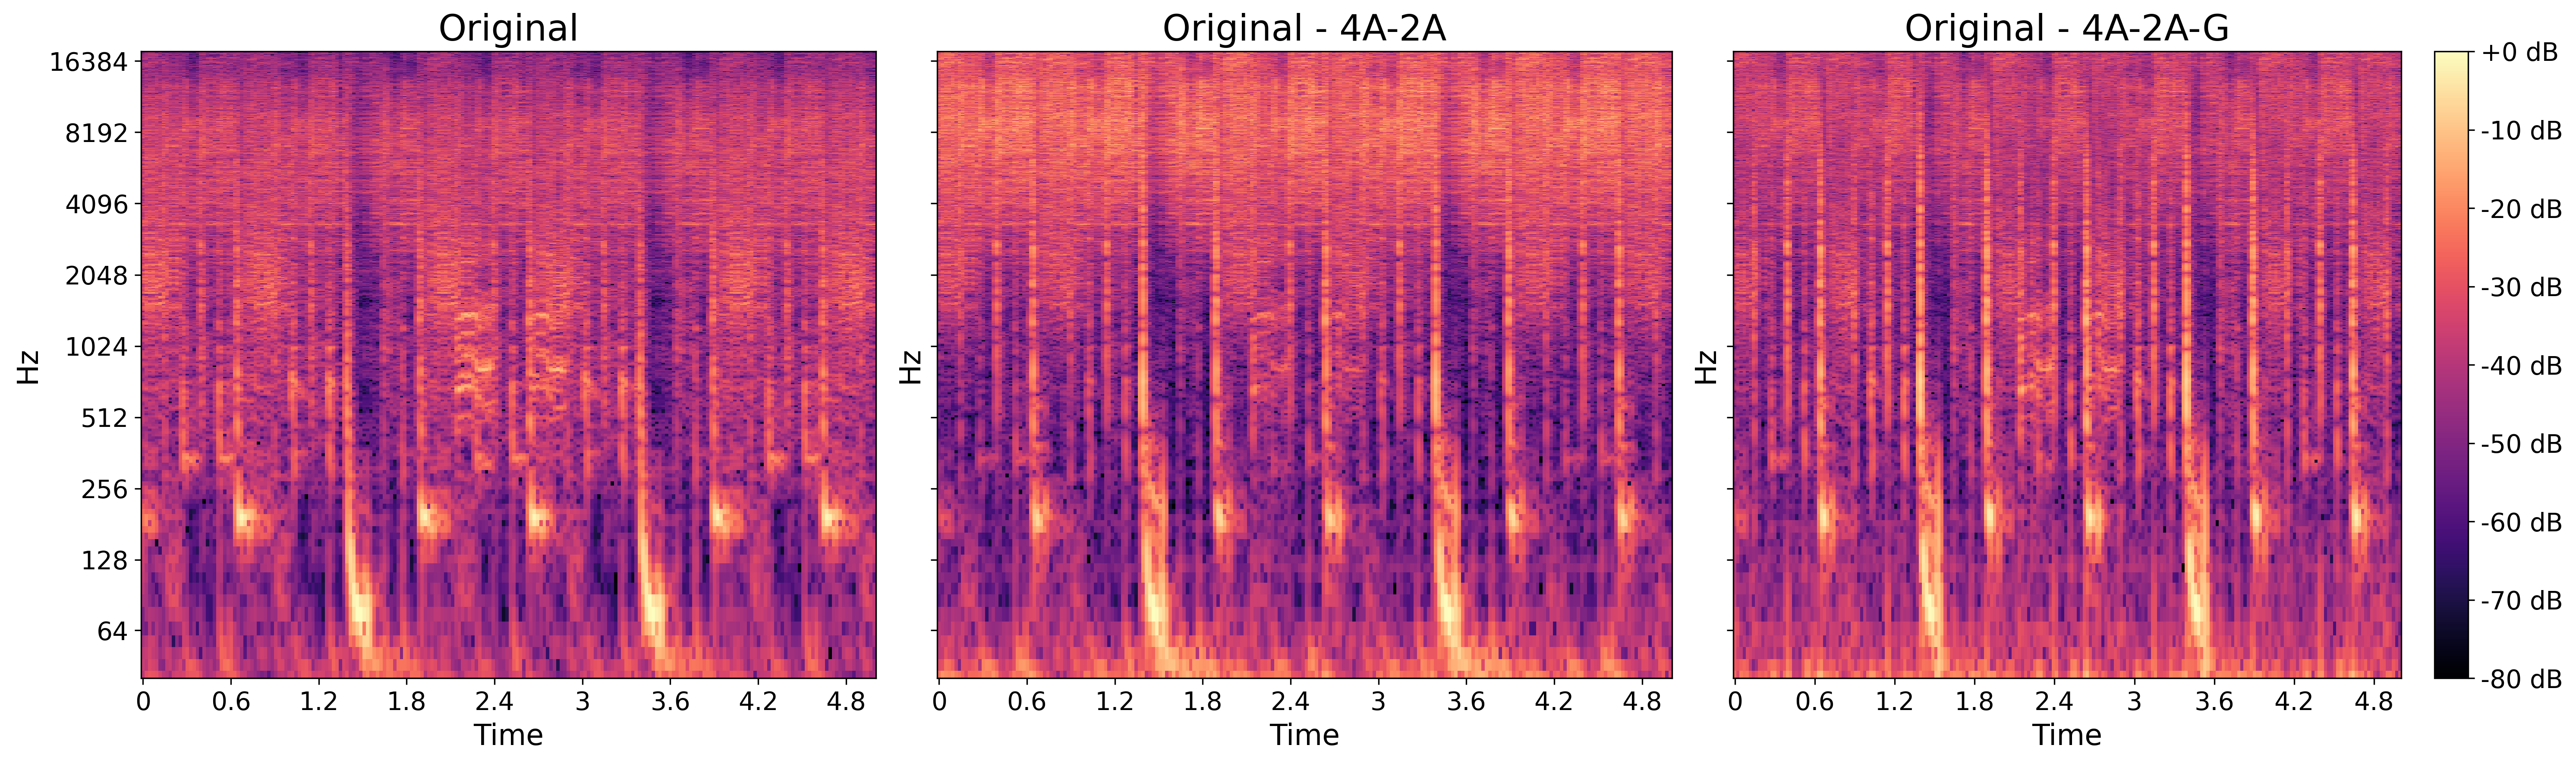

In [7]:
stft = chain_functions(
    partial(librosa.stft, n_fft=4096, hop_length=1024),
    np.abs
)
S = stft(gt)
ref = np.max(S)
pred1_S = stft(gt - pred1)
pred2_S = stft(gt - pred2)

# Audio(gt, rate=sr)
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6), dpi=300)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

img = specshow(librosa.amplitude_to_db(S, ref=ref), y_axis='log', x_axis='time', n_fft=4096, hop_length=1024, sr=sr,
               ax=ax[0])
ax[0].set(title='Original')
specshow(librosa.amplitude_to_db(pred1_S, ref=ref), y_axis='log', x_axis='time', n_fft=4096, hop_length=1024, sr=sr,
         ax=ax[1])
ax[1].set(title='Original - 4A-2A')
specshow(librosa.amplitude_to_db(pred2_S, ref=ref), y_axis='log', x_axis='time', n_fft=4096, hop_length=1024, sr=sr,
         ax=ax[2])
ax[2].set(title='Original - 4A-2A-G')
ax[0].set_ylim(20, 18000)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", "5%", pad="5%")
plt.colorbar(img, cax=cax, format="%+2.0f dB")
plt.tight_layout()
# plt.savefig('s5_008_mic1.png')
plt.show()